In [4]:
# Importing required libraries

import tensorflow as tf
from tensorflow import keras
from keras import Sequential,regularizers
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense
from keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU
import matplotlib.pyplot as mpl
import numpy as np

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
from zipfile import ZipFile
zip = ZipFile(r"D:\My Stuff\Data science\Data sets\Images\archive (42).zip")
zip.extractall(r"D:\My Stuff\Data science\Data sets\Images\X-ray data")
zip.close()

In [11]:
# importing image data from directory
train_df = keras.utils.image_dataset_from_directory(
    directory = r"D:\My Stuff\Data science\Data sets\Images\X-ray data\train",
    batch_size = 32,
    image_size = (256,256),
    labels = "inferred",
    label_mode='int'
)

test_df = keras.utils.image_dataset_from_directory(
    directory = r"D:\My Stuff\Data science\Data sets\Images\X-ray data\val",
    batch_size = 32,
    image_size = (256,256),
    labels = "inferred",
    label_mode='int'
)

Found 6326 files belonging to 4 classes.
Found 38 files belonging to 4 classes.


In [7]:
def convert(image,label):
  image = tf.cast(image/256,tf.float32)
  return image,label

In [8]:
train_df = train_df.map(convert)
test_df = test_df.map(convert)

In [ ]:
# Building CNN architecture
first_model = Sequential()

first_model.add(Conv2D(128,kernel_size = (3,3),padding = "valid",activation = "relu",input_shape = (256,256,3)))
first_model.add(Conv2D(128,kernel_size = (3,3),padding = "same",activation = "relu"))
first_model.add(BatchNormalization())
first_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

first_model.add(Conv2D(256,kernel_size = (3,3),padding = "valid",activation = "relu"))
first_model.add(Conv2D(256,kernel_size = (3,3),padding = "same",activation = "relu"))
first_model.add(BatchNormalization())
first_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

first_model.add(Conv2D(512,kernel_size = (3,3),padding = "valid",activation = "relu"))
first_model.add(Conv2D(512,kernel_size = (3,3),padding = "same",activation = "relu"))
first_model.add(Conv2D(512,kernel_size = (3,3),padding = "same",activation = "relu"))
first_model.add(BatchNormalization())
first_model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

first_model.add(Flatten())

first_model.add(Dense(128,activation = "relu",kernel_initializer = "he_uniform",kernel_regularizer=regularizers.L1(0.01)))
first_model.add(Dense(128,activation = "relu",kernel_initializer = "he_uniform",kernel_regularizer=regularizers.L1(0.01)))
first_model.add(Dropout(0.4))
first_model.add(Dense(5,activation = "softmax"))

In [ ]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 128)     147584    
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 256)     295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 256)     5

In [ ]:
first_model.compile(optimizer = "Adam",loss = "sparse_categorical_crossentropy",metrics = "accuracy")

In [12]:
callback = EarlyStopping(
    patience = 5,
    monitor = "val_loss",
    mode = "auto",
)

In [ ]:
history = first_model.fit(train_df,epochs = 1000,validation_data = test_df,callbacks = callback)

Epoch 1/1000
198/198 [==============================] - 311s 1s/step - loss: 192.3327 - accuracy: 0.6614 - val_loss: 99.4147 - val_accuracy: 0.1842
Epoch 2/1000
198/198 [==============================] - 232s 1s/step - loss: 91.4647 - accuracy: 0.7899 - val_loss: 84.6986 - val_accuracy: 0.3947
Epoch 3/1000
198/198 [==============================] - 231s 1s/step - loss: 82.4609 - accuracy: 0.8331 - val_loss: 77.6674 - val_accuracy: 0.4737
Epoch 4/1000
198/198 [==============================] - 230s 1s/step - loss: 76.3657 - accuracy: 0.8631 - val_loss: 75.6127 - val_accuracy: 0.4211
Epoch 5/1000
198/198 [==============================] - 231s 1s/step - loss: 71.8745 - accuracy: 0.8922 - val_loss: 72.3492 - val_accuracy: 0.3684
Epoch 6/1000
198/198 [==============================] - 230s 1s/step - loss: 69.5326 - accuracy: 0.8972 - val_loss: 69.9864 - val_accuracy: 0.3421
Epoch 7/1000
198/198 [==============================] - 229s 1s/step - loss: 67.6943 - accuracy: 0.9067 - val_loss: 6

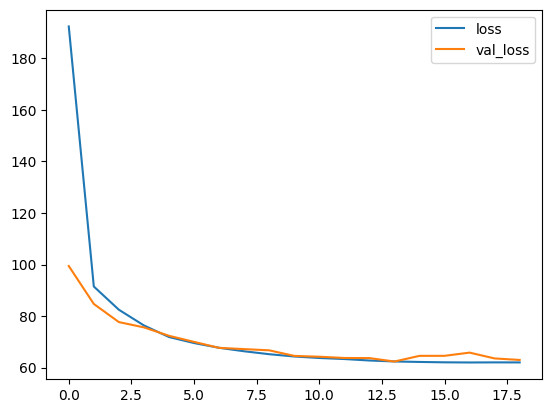

In [ ]:
mpl.plot(history.history["loss"],label = "loss")
mpl.plot(history.history["val_loss"],label = "val_loss")
mpl.legend()
mpl.show()

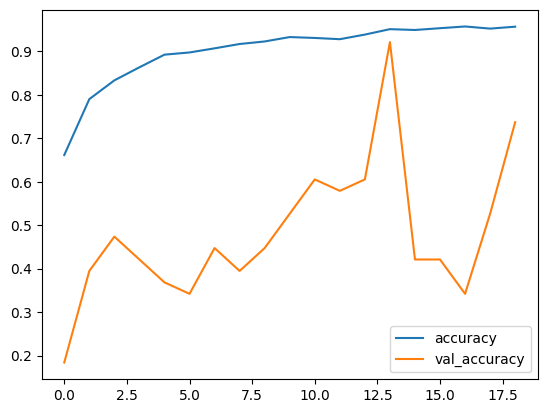

In [ ]:
mpl.plot(history.history["accuracy"],label = "accuracy")
mpl.plot(history.history["val_accuracy"],label = "val_accuracy")
mpl.legend()
mpl.show()

## **Hyperparameter Tuning**

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt

In [ ]:
# Hyperparameter tuning using keras tuner
def build_model(hp):

  model = Sequential()

  model.add(Conv2D(hp.Int("filters", min_value = 32,max_value = 512,step = 32),
                     kernel_size=(3,3),activation = "relu",input_shape = (256,256,3),padding = "valid"))
  model.add(Conv2D(hp.Int("filters", min_value = 32,max_value = 512,step = 32),kernel_size=(3,3),activation = "relu",padding = "same"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

  model.add(Conv2D(hp.Int("filters", min_value = 32,max_value = 512,step = 32),kernel_size=(3,3),activation = "relu",padding = "valid"))
  model.add(Conv2D(hp.Int("filters", min_value = 32,max_value = 512,step = 32),kernel_size=(3,3),activation = "relu",padding = "same"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2,2),strides = (2,2)))

  model.add(Flatten())


  model.add(Dense(hp.Int("unit",min_value = 32,max_value = 128,step = 16),
                  activation = 'relu',kernel_initializer = "he_uniform",
                  kernel_regularizer = regularizers.L1(hp.Choice("val",values = [0.01,0.02,0.03,0.04,0.05]))))
  model.add(Dense(hp.Int("unit",min_value = 32,max_value = 128,step = 16),
                  activation = 'relu',kernel_initializer = "he_uniform",
                  kernel_regularizer = regularizers.L1(hp.Choice("val",values = [0.01,0.02,0.03,0.04,0.05]))))

  model.add(Dense(4,activation = "softmax"))


  model.compile(optimizer = hp.Choice("optimizer",values = ["adam","rmsprop","nadam","sgd","adadelta"]),
                                                loss = "sparse_categorical_crossentropy",metrics = ["accuracy"])
  return model

In [ ]:
tunner = kt.RandomSearch(build_model,objective="val_loss",max_trials=5)

In [ ]:
tunner.search(train_df,epochs = 5,validation_data = test_df)

Trial 5 Complete [00h 24m 37s]
val_loss: 164.9705810546875

Best val_loss So Far: 19.472126007080078
Total elapsed time: 01h 08m 35s


In [ ]:
tunner.get_best_hyperparameters()[0].values

{'filters': 64, 'unit': 80, 'val': 0.01, 'optimizer': 'nadam'}

In [ ]:
model = tunner.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      3

In [ ]:
history = model.fit(train_df,epochs = 1000,initial_epoch=11,validation_data = test_df,callbacks = callback)

Epoch 12/1000
198/198 [==============================] - 78s 351ms/step - loss: 19.1616 - accuracy: 0.9211 - val_loss: 19.5289 - val_accuracy: 0.7105
Epoch 13/1000
198/198 [==============================] - 69s 339ms/step - loss: 18.8415 - accuracy: 0.9308 - val_loss: 19.0743 - val_accuracy: 0.8421
Epoch 14/1000
198/198 [==============================] - 61s 298ms/step - loss: 18.6135 - accuracy: 0.9350 - val_loss: 18.4341 - val_accuracy: 0.9474
Epoch 15/1000
198/198 [==============================] - 62s 300ms/step - loss: 18.5209 - accuracy: 0.9322 - val_loss: 19.6862 - val_accuracy: 0.6579
Epoch 16/1000
198/198 [==============================] - 61s 295ms/step - loss: 18.3523 - accuracy: 0.9410 - val_loss: 19.1798 - val_accuracy: 0.6053
Epoch 17/1000
198/198 [==============================] - 62s 303ms/step - loss: 18.2528 - accuracy: 0.9469 - val_loss: 19.9914 - val_accuracy: 0.5789
Epoch 18/1000
198/198 [==============================] - 61s 297ms/step - loss: 18.2808 - accuracy: 

In [ ]:
import matplotlib.pyplot as mpl

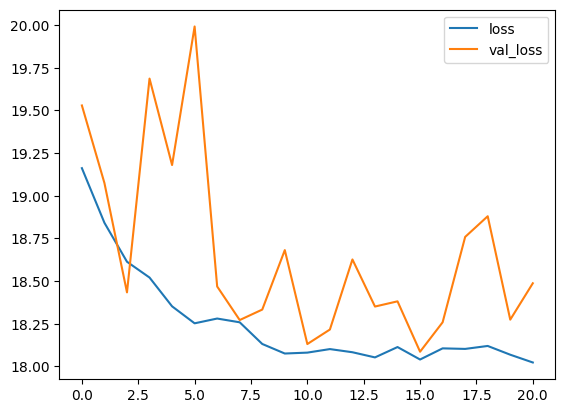

In [ ]:
mpl.plot(history.history["loss"],label = "loss")
mpl.plot(history.history["val_loss"],label = "val_loss")
mpl.legend()
mpl.show()

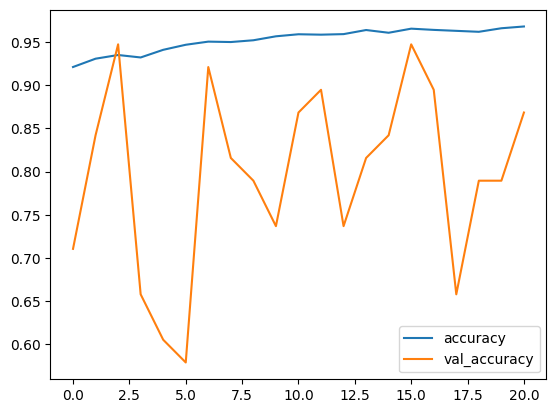

In [ ]:
mpl.plot(history.history["accuracy"],label = "accuracy")
mpl.plot(history.history["val_accuracy"],label = "val_accuracy")
mpl.legend()
mpl.show()

## **Transfer learning**

In [49]:
from keras.applications import vgg16

In [50]:
vgg_model = Sequential()

In [51]:
conv_layers = vgg16.VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (256,256,3)
)

In [52]:
conv_layers.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
conv_layers.get_weights()

In [54]:
vgg_model.add(conv_layers)

vgg_model.add(Flatten())

vgg_model.add(Dense(64,activation = "relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.L1(0.01)))
vgg_model.add(Dense(128,activation = "relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.L1(0.01)))

vgg_model.add(Dense(4,activation = "softmax"))

In [55]:
conv_layers.trainable = False

In [56]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                2097216   
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 16,820,740
Trainable params: 2,106,052
Non-trainable params: 14,714,688
_________________________________________________________________


In [57]:
vgg_model.compile(optimizer = "Adam",loss = "sparse_categorical_crossentropy",metrics = "accuracy")

In [58]:
history = vgg_model.fit(train_df,epochs = 1000,validation_data = test_df,callbacks = callback)

Epoch 1/1000
198/198 [==============================] - 54s 253ms/step - loss: 16.8069 - accuracy: 0.8119 - val_loss: 6.9449 - val_accuracy: 0.6579
Epoch 2/1000
198/198 [==============================] - 51s 250ms/step - loss: 5.0744 - accuracy: 0.8658 - val_loss: 4.8898 - val_accuracy: 0.6316
Epoch 3/1000
198/198 [==============================] - 52s 251ms/step - loss: 3.9190 - accuracy: 0.8748 - val_loss: 4.2301 - val_accuracy: 0.6053
Epoch 4/1000
198/198 [==============================] - 51s 248ms/step - loss: 3.5180 - accuracy: 0.8947 - val_loss: 3.7318 - val_accuracy: 0.6579
Epoch 5/1000
198/198 [==============================] - 51s 249ms/step - loss: 3.3926 - accuracy: 0.8776 - val_loss: 3.4711 - val_accuracy: 0.7632
Epoch 6/1000
198/198 [==============================] - 51s 247ms/step - loss: 3.1809 - accuracy: 0.8930 - val_loss: 4.2084 - val_accuracy: 0.5263
Epoch 7/1000
198/198 [==============================] - 52s 253ms/step - loss: 3.0975 - accuracy: 0.8966 - val_loss: 

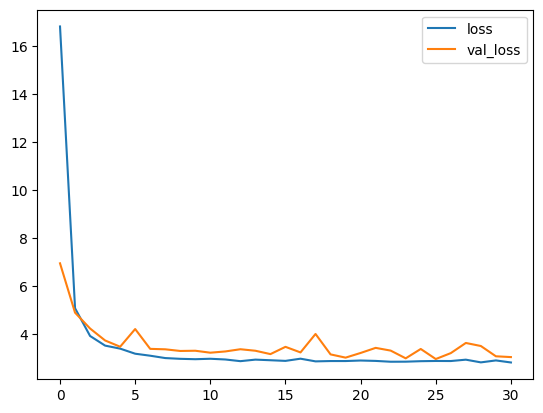

In [59]:
mpl.plot(history.history["loss"],label = "loss")
mpl.plot(history.history["val_loss"],label = "val_loss")
mpl.legend()
mpl.show()

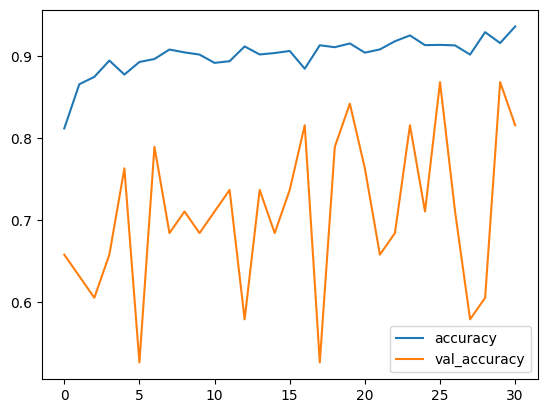

In [60]:
mpl.plot(history.history["accuracy"],label = "accuracy")
mpl.plot(history.history["val_accuracy"],label = "val_accuracy")
mpl.legend()
mpl.show()